In [409]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [410]:
%autoreload 2
import itertools as itt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import mannwhitneyu
from sdeint import itoint
from spynal.spectra.multitaper import multitaper_spectrogram
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from sklearn.decomposition import PCA
import sys
from tqdm.auto import tqdm

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *

sys.path.append('../..')
from plot_utils import *

In [3]:
def compute_lyaps(Js, dt=1, k=None, worker_num=None, message_queue=None, verbose=False):
    T, n = Js.shape[0], Js.shape[1]
    old_Q = np.eye(n)
    if k is None:
        k = n
    old_Q = old_Q[:, :k]
    lexp = np.zeros(k)
    lexp_counts = np.zeros(k)
    for t in tqdm(range(T), disable=not verbose):
        # QR-decomposition of Js[t] * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(Js[t], old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
#         print(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)
        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)

#         print(diag_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
#         lexp_i[np.where(diag_R == 0)] = np.inf
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

        # it may happen that all R-matrices contained zeros => exponent really has
        # to be -inf

        # normalize exponents over number of individual mat_Rs
#         idx = np.where(lexp_counts > 0)
        #lexp[idx] /= lexp_counts[idx]
#         lexp[np.where(lexp_counts == 0)] = np.inf

        if message_queue is not None:
            message_queue.put((worker_num, "task complete", "DEBUG"))
    
    return np.divide(lexp, lexp_counts)*(1/dt)

In [239]:
save_dir = "/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/Testing/Lorenz"
os.makedirs(save_dir, exist_ok=True)

# Lorenz

In [419]:
# def lorenz(state, t, sigma=10, rho=28, beta=8/3):
#     x, y, z = state
#     dxdt = sigma * (y - x)
#     dydt = x * (rho - z) - y
#     dzdt = x * y - beta * z
#     return [dxdt, dydt, dzdt]

# def lorenz_jacobian(state, sigma=10, rho=28, beta=8/3):
#     x, y, z = state
#     jacobian = np.array([
#         [-sigma, sigma, 0],
#         [rho - z, -1, -x],
#         [y, x, -beta]
#     ])
#     return jacobian

In [420]:
t_span = [0, 50]
dt = 0.001
# rhos = [28, 99.7]
# rhos = [28, 24]
a_vals = [0.1, 0.2]

# num_trajs = 10
num_trajs = 1

transient = 10000
train_window = 20000
test_window = 10000

# obs_noise_scale = 2e-1
obs_noise_scale = 2e-1

train_inds = np.arange(transient, transient + train_window)
test_inds = np.arange(transient + train_window, transient + train_window + test_window)

t_eval = np.arange(t_span[0], t_span[1], dt)

In [395]:
# rho = 28
trajectories = {}
for rho in rhos:
    np.random.seed(42)
    x = np.zeros((num_trajs, len(t_eval), 3))
    for num_traj in range(num_trajs):
        y0 = np.random.randn(3)
        sol = solve_ivp(lambda t, x: lorenz(x, t, rho=rho), y0=y0, t_span=t_span, t_eval=t_eval)
        x[num_traj] = sol.y.T
    trajectories[rho] = x + np.random.randn(*x.shape)*obs_noise_scale

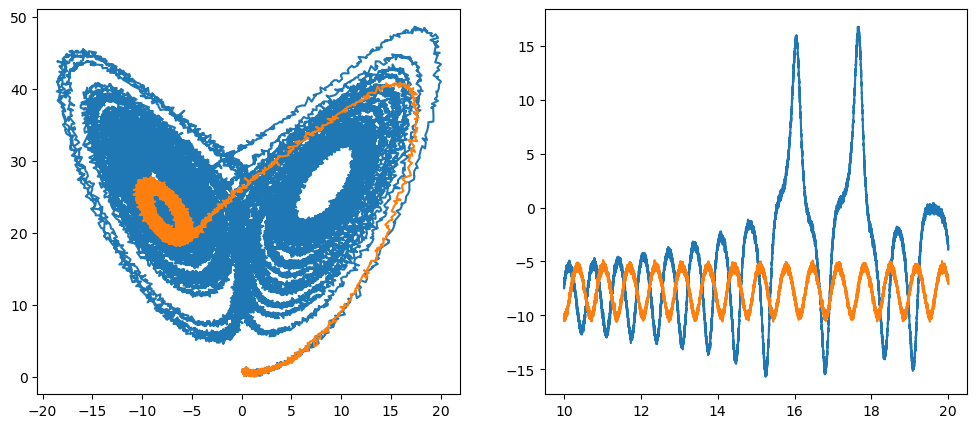

In [396]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for rho, x in trajectories.items():
    ax = axs[0]
    ax.plot(x[0, :, 0], x[0, :, 2])

    ax = axs[1]
    ax.plot(t_eval[transient:transient + 10000], x[0, transient:transient + 10000, 0])
plt.show()

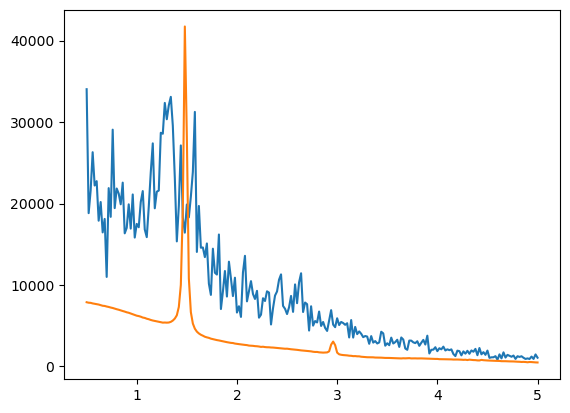

In [397]:
min_freq = 0.5
max_freq = 5

for rho, x in trajectories.items():
    fft_mag = np.abs(np.fft.rfft(x.transpose(0, 2, 1).reshape(-1, x.shape[1]))).mean(axis=0)
    freqs = np.fft.rfftfreq(x.shape[1], d=dt)
    
    freq_inds = (freqs >= min_freq) & (freqs <= max_freq)
    plt.plot(freqs[freq_inds], fft_mag[freq_inds])
plt.show()

In [399]:
jacobians = {}

# time_pts = t_eval
time_pts = train_inds

for rho, x in trajectories.items():
    jacs = np.zeros((num_trajs, len(time_pts), 3, 3))
    for num_traj in range(num_trajs):
        # if time_pts == t_eval:
        # jacs[num_traj] = np.array([lorenz_jacobian(x[num_traj, t], rho=rho) for t in range(x.shape[1])])
        jacs[num_traj] = np.array([lorenz_jacobian(x[num_traj, t], rho=rho) for t in train_inds])
    jacobians[rho] = jacs

In [400]:
lyaps = {}
for rho, jacobian_mats in tqdm(jacobians.items()):
    lyap_vals = np.zeros((num_trajs, 3))
    for num_traj in range(num_trajs):
        lyap_vals[num_traj] = compute_lyaps(np.eye(3) + dt*jacobian_mats[num_traj], dt=dt)
    lyaps[rho] = lyap_vals

  0%|          | 0/2 [00:00<?, ?it/s]

In [401]:
for rho in rhos:
    print(f"{rho}: {lyaps[rho].mean(axis=0)}")

28: [ 8.08816088e-01 -9.95723430e-03 -1.44940172e+01]
24: [  0.08001039  -0.03171469 -13.72157733]


In [411]:
subsample = 1
max_freq = (1/(dt*subsample))/2
# n_delays_vals = [1, 2, 5, 10, 15, 20, 30, 40, 50]
# rank_vals = [1, 2, 5, 10, 15, 20, 30, 40, 50]

# n_delays_vals = [1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
n_delays_vals = [120, 130, 140, 150, 160]
# rank_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
rank_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]
# n_delays_vals = [1, 2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200]
# rank_vals = [1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 112, 125, 137, 150, 162, 175, 187, 200]


all_delase_results = []

iterator = tqdm(total=num_trajs*len(rhos)*len(n_delays_vals)*len(rank_vals))

for num_traj in range(num_trajs):
    # print("-"*20)
    # print(f"NUM_TRAJ = {num_traj}")
    delase_results = {}
    
    for rho in rhos:
        # print("-"*20)
        # print(f"MU = {mu}")
        x = trajectories[rho]
        x = x[num_traj, ::subsample]
        # x = x[::subsample]
        x = x[:, [0]]
        
        aic_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
        mase_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
        stab_mean_mat3 = np.zeros((len(n_delays_vals), len(rank_vals)))
        stab_mean_mat10p = np.zeros((len(n_delays_vals), len(rank_vals)))
        delase_evals3 = np.zeros((len(n_delays_vals), len(rank_vals)))
        delase_evals10p = np.zeros((len(n_delays_vals), len(rank_vals)))
        
        for i, n_delays in enumerate(n_delays_vals):
            delase = DeLASE(x[train_inds], n_delays=n_delays, rank=n_delays*x.shape[-1], dt=dt*subsample, max_freq=max_freq, max_unstable_freq=max_freq, device='cuda')
            delase.DMD.compute_hankel()
            delase.DMD.compute_svd()
            for j, rank in enumerate(rank_vals):
                if rank <= n_delays*x.shape[-1]:
                    
                    delase.DMD.compute_havok_dmd(rank=rank)
                    preds = delase.DMD.predict(x[test_inds])
                    aic_mat[i, j] = float(aic(torch.from_numpy(x[test_inds]).cuda(), preds, k=rank**2).cpu().numpy())
                    mase_mat[i, j] = float(mase(torch.from_numpy(x[test_inds]).cuda(), preds).cpu().numpy())
                    delase.get_stability()
                    stab_mean_mat3[i, j] = delase.stability_params[:3].mean().cpu().numpy()
                    num_params = np.min((int(0.1*len(delase.stability_params)), rank))
                    stab_mean_mat10p[i, j] = delase.stability_params[:num_params].mean().cpu().numpy()

                    I = torch.eye(delase.DMD.A_havok_dmd.shape[0]).cuda()
                    evals = torch.linalg.eigvals((delase.DMD.A_havok_dmd - I)/dt)
                    evals, freqs = torch.real(evals), torch.imag(evals)/(2*np.pi)
                    sort_inds = torch.flip(torch.sort(evals).indices, dims=(0,))
                    evals, freqs = evals[sort_inds], freqs[sort_inds]
                    freq_inds = freqs <= max_freq
                    evals = evals[freq_inds]
                    freqs = freqs[freq_inds]
                    delase_evals3[i, j] = evals[:3].mean().cpu().numpy()
                    num_evals = np.min((int(0.1*len(evals)), rank))
                    delase_evals10p[i, j] = evals[:num_evals].mean().cpu().numpy()
                    
                else:
                    aic_mat[i, j] = np.Inf
                iterator.update()
    
        delase_results[rho] = dict(
            train_inds=train_inds,
            test_inds=test_inds,
            aic_mat=aic_mat,
            mase_mat=mase_mat,
            stab_mean_mat3=stab_mean_mat3,
            stab_mean_mat10p=stab_mean_mat10p,
            delase_evals3=delase_evals3,
            delase_evals10p = delase_evals10p
        )

    all_delase_results.append(delase_results)
    
iterator.close()

  0%|          | 0/520 [00:00<?, ?it/s]

In [412]:
rhos_to_use = rhos

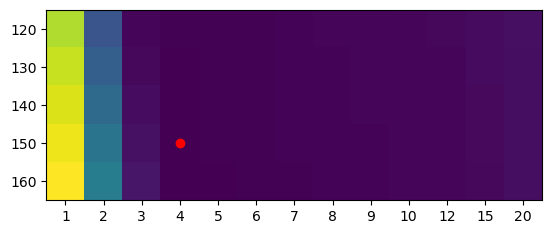

In [414]:
aic_mat_all = np.ones((num_trajs, len(rhos_to_use), len(n_delays_vals), len(rank_vals)))
mase_mat_all = np.ones((num_trajs, len(rhos_to_use), len(n_delays_vals), len(rank_vals)))
for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, rho in enumerate(rhos_to_use):
        aic_mat_all[num_traj, ind] = delase_results[rho]['aic_mat']
        mase_mat_all[num_traj, ind] = delase_results[rho]['mase_mat']
# aic_mat /= len(rhos_to_use)
aic_mat = aic_mat_all.mean(axis=(0, 1))
mase_mat = mase_mat_all.mean(axis=(0, 1))
i, j = np.unravel_index(aic_mat.argmin(), shape=aic_mat.shape)
n_delays = n_delays_vals[i]
rank = rank_vals[j]
# n_delays = 200
# rank = 15
# rank = 12
# rank = 8
# j = np.where(np.array(rank_vals) == rank)[0][0]

plt.imshow(aic_mat)
plt.scatter(j, i, c='r')
plt.xticks(np.arange(len(rank_vals)), rank_vals)
plt.yticks(np.arange(len(n_delays_vals)), n_delays_vals)
plt.show()

# for num_traj in range(num_trajs):
#     for rho in rhos:
#         if rho in rhos_to_use:
#             # print("-"*20)
#             # print(f"MU = {mu}")
#             x = trajectories[rho]
#             x = x[num_traj, ::subsample]
#             # x = x[::subsample]
#             x = x[:, [0]]
        
#             delase = DeLASE(x[train_inds], n_delays = n_delays, rank=rank, dt=dt*subsample, device='cuda', max_freq=max_freq, max_unstable_freq=max_freq)
#             delase.fit()
#             delase.to('cpu')
#             preds = delase.DMD.predict(x[test_inds])
        
#             all_delase_results[num_traj][rho] = all_delase_results[num_traj][rho] | dict(delase=delase, n_delays=n_delays, rank=rank)
    
#     for mu in mus[:-1]:
#         stab_params = delase_results[mu]['delase'].stability_params.cpu()
#         plt.plot(stab_params[:int(0.1*len(stab_params))], label=fr"$\mu$ = {mu}")
#     plt.legend()
#     plt.show()


In [415]:
aic_mat[i, j], aic_mat[i, j-1]

(-3.133464193572863, -2.9517963416900304)

In [416]:
# plt.subplot(1, 2, 1)
# plt.imshow(aic_mat_all[11][0])

# plt.subplot(1, 2, 2)
# plt.imshow(aic_mat_all[11][1])

In [417]:
aic_mat[i, j], aic_mat[i, j + 1]

(-3.133464193572863, -3.115802758163915)

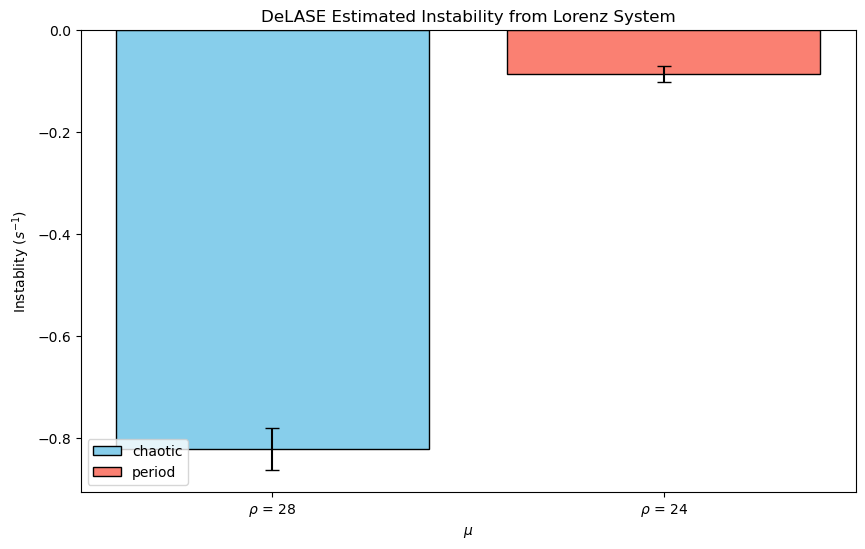

In [418]:
plt.figure(figsize=(10, 6))

stab_means = np.zeros((num_trajs, len(rhos_to_use)))
delase_evals = np.zeros((num_trajs, len(rhos_to_use)))

for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, rho in enumerate(rhos_to_use):
        stab_means[num_traj, ind] = delase_results[rho]['stab_mean_mat3'][i, j]
        # stab_means[num_traj, ind] = delase_results[rho]['stab_mean_mat10p'][i, j]
        # delase_evals[num_traj, ind] = delase_results[rho]['delase_eval_mat3'][i, j]

# for num_traj, delase_results in enumerate(all_delase_results):
#     labels = []
#     for ind, rho in enumerate(rhos_to_use):
#         stab_params = delase_results[rho]['delase'].stability_params
#         # stab_means[num_traj, ind] = stab_params[:int(0.1*len(stab_params))].mean()
#         # stab_means[num_traj, ind] = stab_params[:2].mean()
#         # print(int(0.2*len(stab_params)))
#         # stab_means[num_traj, ind] = stab_params[:3].mean()
#         stab_means[num_traj, ind] = stab_params[:int(0.1*len(stab_params))].mean()

#         delase = delase_results[rho]['delase']
#         evals = torch.real(torch.linalg.eigvals((delase.DMD.A_havok_dmd - torch.eye(delase.DMD.A_havok_dmd.shape[0]))/dt))
#         evals = torch.flip(torch.sort(evals).values, dims=(0,))

#         # delase_evals[num_traj, ind] = evals[:3].mean()
#         delase_evals[num_traj, ind] = evals[:int(0.1*len(evals))].mean()

# Create the scatter plot with error bars
mean_vals = stab_means.mean(axis=0)
se_vals = stab_means.std(axis=0)/np.sqrt(stab_means.shape[0])

# plt.errorbar(np.arange(len(pairs_to_use)), mean_vals, yerr=se_vals, fmt='o', ecolor='r', capsize=5)
colors = ['skyblue' if rho == 28 else 'salmon' for rho in rhos_to_use]
plt.bar(np.arange(len(rhos_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
plt.xticks(np.arange(len(rhos_to_use)), [fr"$\rho$ = {rho}" for rho in rhos_to_use])

plt.xlabel("$\mu$")
plt.ylabel("Instablity ($s^{-1}$)")

plt.title("DeLASE Estimated Instability from Lorenz System")

# Create legend
legend_labels = {'chaotic': "chaotic", 'stable': 'period'}
legend_handles = [plt.Rectangle((0,0),1,1, color='skyblue', ec='black', lw=1, label=legend_labels['chaotic']),
                  plt.Rectangle((0,0),1,1, color='salmon', ec='black', lw=1, label=legend_labels['stable'])]
plt.legend(handles=legend_handles, loc='lower left')

# Display the plot
# clear_axes(plt.gca())
plt.show()

In [380]:
mannwhitneyu(stab_means[:, 0], stab_means[:, 1], alternative='greater')

MannwhitneyuResult(statistic=0.0, pvalue=0.9999999999999998)

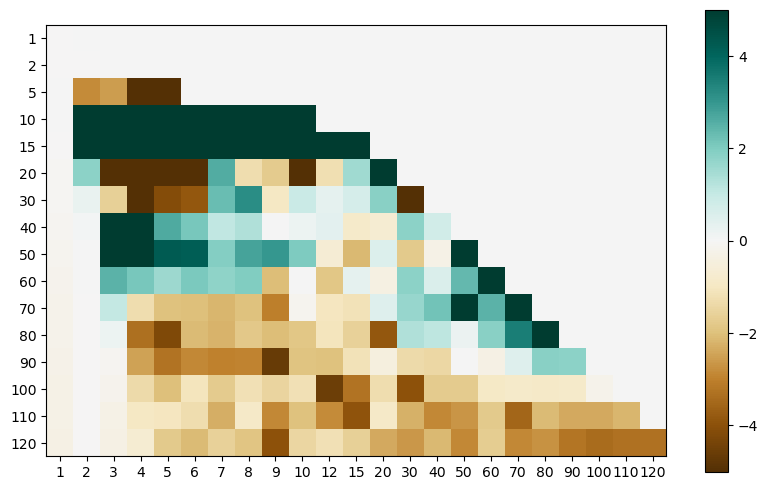

In [381]:
stab_means_all = np.zeros((num_trajs, len(rhos_to_use), len(n_delays_vals), len(rank_vals)))
# delase_evals_all = np.zeros((num_trajs, len(rhos_to_use), len(n_delays_vals), len(rank_vals)))
for i in range(len(n_delays_vals)):
    for j in range(len(rank_vals)):
        for num_traj in range(num_trajs):
            delase_results = all_delase_results[num_traj]
            for ind, rho in enumerate(rhos_to_use):
                stab_means_all[num_traj, ind] = delase_results[rho]['stab_mean_mat3']
            

# fig, axs = plt.subplots(len(n_delays_vals), len(rank_vals), figsize=(20, 12))

stab_all_mean = stab_means_all.mean(axis=0)
stab_all_se = stab_means_all.std(axis=0)/np.sqrt(num_trajs)

diff = stab_all_mean[0] - stab_all_mean[1]
# norm = TwoSlopeNorm(vmin=diff.min(), vcenter=0, vmax=diff.max())
norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
plt.figure(figsize=(10, 6))
plt.imshow(diff, cmap='BrBG', norm=norm)
plt.xticks(np.arange(len(rank_vals)), rank_vals)
plt.yticks(np.arange(len(n_delays_vals)), n_delays_vals)
plt.colorbar()

# for ind, rho in enumerate(rhos_to_use):
#     for i in range(len(n_delays_vals)):
#         for j in range(len(rank_vals)):
#             ax = axs[i][j]
#             ax.bar(rho, stab_all_mean[ind, i, j], yerr=stab_all_se[ind, i, j], color="skyblue" if rho == 28 else "salmon")

In [373]:
# plt.scatter(aic_mat.flatten(), diff.flatten())

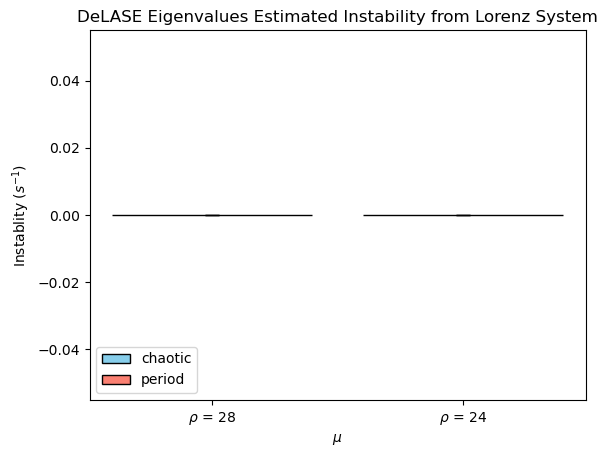

In [374]:
# Create the scatter plot with error bars
mean_vals = delase_evals.mean(axis=0)
se_vals = delase_evals.std(axis=0)/np.sqrt(stab_means.shape[0])

# plt.errorbar(np.arange(len(pairs_to_use)), mean_vals, yerr=se_vals, fmt='o', ecolor='r', capsize=5)
colors = ['skyblue' if rho == 28 else 'salmon' for rho in rhos_to_use]
plt.bar(np.arange(len(rhos_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
plt.xticks(np.arange(len(rhos_to_use)), [fr"$\rho$ = {rho}" for rho in rhos_to_use])

plt.xlabel("$\mu$")
plt.ylabel("Instablity ($s^{-1}$)")

plt.title("DeLASE Eigenvalues Estimated Instability from Lorenz System")

# Create legend
legend_labels = {'chaotic': "chaotic", 'stable': 'period'}
legend_handles = [plt.Rectangle((0,0),1,1, color='skyblue', ec='black', lw=1, label=legend_labels['chaotic']),
                  plt.Rectangle((0,0),1,1, color='salmon', ec='black', lw=1, label=legend_labels['stable'])]
plt.legend(handles=legend_handles, loc='lower left')

# Display the plot
# clear_axes(plt.gca())
plt.show()

In [144]:
delase_evals

array([[-370.0559082 , -251.53938293],
       [-353.29626465, -149.26170349],
       [-415.40863037, -217.75836182],
       [-559.15771484, -346.99197388],
       [-380.3821106 , -168.06408691],
       [-262.97503662, -175.5116272 ],
       [-343.03277588, -268.02511597],
       [-350.45498657, -243.95605469],
       [-370.28781128, -246.33621216],
       [-325.48074341, -195.65507507]])

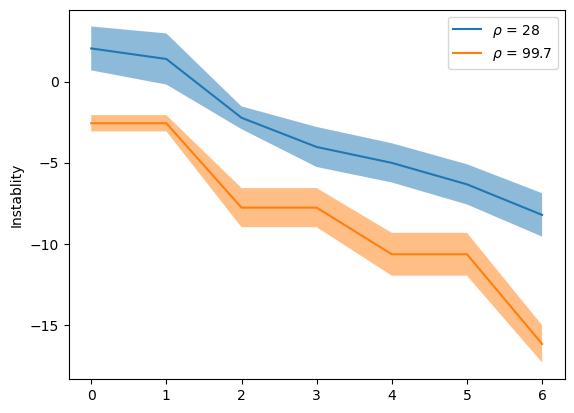

In [145]:
top_percent = 0.1

stab_means = np.zeros((num_trajs, len(rhos_to_use), int(top_percent*len(stab_params))))

for num_traj, delase_results in enumerate(all_delase_results):
    labels = []
    for ind, rho in enumerate(rhos_to_use):
        stab_params = delase_results[rho]['delase'].stability_params
        stab_means[num_traj, ind] = stab_params[:int(top_percent*len(stab_params))].cpu()[:stab_means.shape[2]]

# Create the scatter plot with error bars
mean_vals = stab_means.mean(axis=0)
se_vals = stab_means.std(axis=0)/np.sqrt(stab_means.shape[0])

for ind, rho in enumerate(rhos_to_use):
    plt.plot(mean_vals[ind], label=fr"$\rho$ = {rho}")
    plt.fill_between(np.arange(len(mean_vals[ind])), mean_vals[ind] - se_vals[ind], mean_vals[ind] + se_vals[ind], alpha=0.5)
# plt.xlabel("$\mu$")
plt.ylabel("Instablity")
# Display the plot
plt.legend()
plt.show()

In [242]:
save_dict = dict(
    all_delase_results,
    n_delays_vals=n_delays_vals,
    rank_vals=rank_vals,
    t_span=t_span,
    dt=dt,
    rhos=rhos,
    num_trajs=num_trajs,
    transient=transient,
    train_window=train_window,
    test_window=test_window,
    obs_noise_scale=obs_noise_scale
)
pd.to_pickle(save_dict, os.path.join(save_dir, "big_run.pkl"))